/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  del sys.path[0]
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


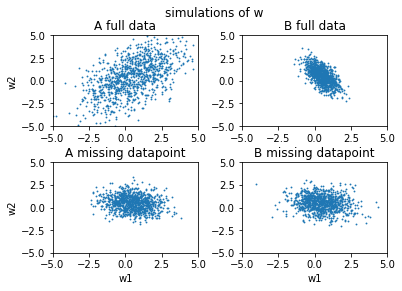

In [46]:
import numpy as np
import matplotlib.pyplot as plt

o2 = 1
N = 1000

#full data
w0A = np.random.multivariate_normal([1/2,1/2],o2*np.array([[3,2],[2,4]]),size=N)
w0B = np.random.multivariate_normal([1/2,1/2],o2*np.array([[1/3,-1/3],[-1/3,5/6]]),size=N)

#missing one datapoint
w1A = np.random.multivariate_normal([1/2,1/2],o2*np.array([[1,-1/2],[-1/2,-1/2]]),size=N)
w1B = np.random.multivariate_normal([1/2,1/2],o2*np.array([[1,-1/2],[-1/2,-1/2]]),size=N)

w = [[w0A,w0B],[w1A,w1B]]
w_name = [['A full data','B full data'],["A missing datapoint","B missing datapoint"]]

fig, ax = plt.subplots(nrows=2,ncols=2)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for i in range(2):
    for j in range(2):
        ax[i][j].scatter(w[i][j].transpose()[0],w[i][j].transpose()[1],s=0.7)
        ax[i][j].set_title(w_name[i][j])
        ax[i][j].set_xlim([-5,5])
        ax[i][j].set_ylim([-5,5])
        if i==1:
            ax[i][j].set_xlabel('w1')
        if j==0:
            ax[i][j].set_ylabel('w2')
fig.suptitle('simulations of w')
fig.show()


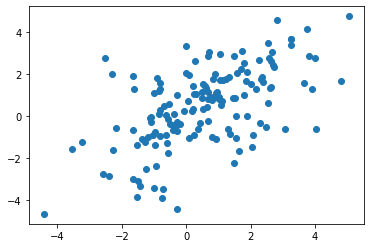

In [22]:
plt.scatter(w[i][j].transpose()[0],w[i][j].transpose()[1])